# Streaming

## Review

In module 2, covered a few ways to customize graph state and memory.

We built up to a Chatbot with external memory that can sustain long-running conversations.

## Goals

This module will dive into `human-in-the-loop`, which builds on memory and allows users to interact directly with graphs in various ways.

To set the stage for `human-in-the-loop`, we'll first dive into streaming, which provides several ways to visualize graph output (e.g., node state or chat model tokens) over the course of execution.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_google_genai langgraph_sdk

## Streaming

LangGraph is built with [first class support for streaming](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

Let's set up our Chatbot from Module 2, and show various way to stream outputs from the graph during execution.

In [1]:
from langchain_openai import ChatOpenAI
import os
from dotenv import load_dotenv
import os
load_dotenv(r"H:\My_LangGraph_toturial\.env")

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = os.getenv(var)
        print("var" , var)
        print("key" , os.getenv(var))
_set_env("OPENAI_API_KEY")

openai_api_key = os.getenv("OPENAI_API_KEY")

In [3]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

Note that we use `RunnableConfig` with `call_model` to enable token-wise streaming. This is [only needed with python < 3.11](https://langchain-ai.github.io/langgraph/how-tos/streaming-tokens/). We include in case you are running this notebook in CoLab, which will use python 3.x.

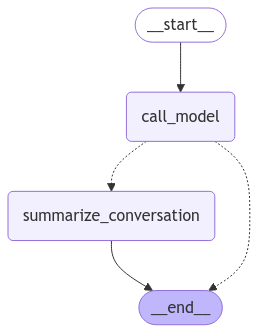

In [7]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph.state import CompiledStateGraph

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
model : ChatOpenAI = ChatOpenAI(model = "gpt-3.5-turbo-0125" , max_tokens=100)

# State
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):
    print("----Node: call_model----")
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    print("----Node: summarize_conversation----")
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    print("----Node: should_continue----")
    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

# Define a new graph
workflow: StateGraph = StateGraph(State)
workflow.add_node("call_model", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "call_model")
workflow.add_conditional_edges("call_model", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory: MemorySaver = MemorySaver()
graph: CompiledStateGraph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Streaming full state

Now, let's talk about ways to [stream our graph state](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

`.stream` and `.astream` are sync and async methods for streaming back results.

LangGraph supports a few [different streaming modes](https://langchain-ai.github.io/langgraph/how-tos/stream-values/) for [graph state](https://langchain-ai.github.io/langgraph/how-tos/stream-values/):

* `values`: This streams the full state of the graph after each node is called.
* `updates`: This streams updates to the state of the graph after each node is called.

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

Let's look at `stream_mode="updates"`.

Because we stream with `updates`, we only see updates to the state after node in the graph is run.

Each `chunk` is a dict with `node_name` as the key and the updated state as the value.

In [22]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    print(chunk)
    print("---"*25)


----Node: call_model----
----Node: should_continue----
{'call_model': {'messages': AIMessage(content='Hello again, Lance! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 118, 'total_tokens': 131, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-8e8aa178-b34f-492a-a69d-0ff1b06455c5-0', usage_metadata={'input_tokens': 118, 'output_tokens': 13, 'total_tokens': 131, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}
---------------------------------------------------------------------------


In [23]:

history = graph.get_state(config).values.get("messages")
for m in history:
    m.pretty_print()

================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hello Lance! How can I assist you this time?
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hello again, Lance! How can I help you today?


Let's now just print the state update.

In [24]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    chunk['call_model']["messages"].pretty_print()

----Node: call_model----
----Node: should_continue----
================================== Ai Message ==================================

Hello, Lance! How can I assist you today? If you have any questions or need help with something, feel free to let me know.


Now, we can see `stream_mode="values"`.

This is the `full state` of the graph after the `conversation` node is called.

In [25]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Talib")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    print(event)
    # for m in event['messages']:
    #     m.pretty_print()
    print("---"*25)

{'messages': [HumanMessage(content="hi! I'm Talib", additional_kwargs={}, response_metadata={}, id='1cef8918-5695-43a0-b0f2-598fe2eab83e')]}
---------------------------------------------------------------------------
----Node: call_model----
----Node: should_continue----
{'messages': [HumanMessage(content="hi! I'm Talib", additional_kwargs={}, response_metadata={}, id='1cef8918-5695-43a0-b0f2-598fe2eab83e'), AIMessage(content='Hi Talib! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 13, 'total_tokens': 25, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-eae0735a-1d01-4a21-aabe-468fbb061815-0', usage_metadata={'input_token

### Streaming tokens

We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the tokens as they are generated.

We can do this [using the `.astream_events` method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node), which streams back events as they happen inside nodes!

Each event is a dict with a few keys:

* `event`: This is the type of event that is being emitted.
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.

Let's have a look.

In [12]:
config = {"configurable": {"thread_id": "3"}}

input_message = HumanMessage(content="Tell me about the 49ers NFL team")

async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):

    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: __start__. Type: on_chain_start. Name: __start__
Node: __start__. Type: on_chain_end. Name: __start__
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversati

The central point is that tokens from chat models within your graph have the `on_chat_model_stream` type.

We can use `event['metadata']['langgraph_node']` to select the node to stream from.

And we can use `event['data']` to get the actual data for each event, which in this case is an `AIMessageChunk`.

In [14]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='## The', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'safety_ratings': []}, id='run-ce8c38fe-970a-4e17-83ca-8230f92246ce', usage_metadata={'input_tokens': 11, 'output_tokens': 2, 'total_tokens': 13})}
{'chunk': AIMessageChunk(content=' San Francisco 49ers: A Legacy of Success and Grit\n\nThe San Francisco 4', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-ce8c38fe-970a-4e17-83ca-8230f92246ce', usage_metadata={'input_tokens': 11, 'output_tokens': 21, 'total_tokens': 32})}
{'chunk': AIMessageChunk(content='9ers are one of

As you see above, just use the `chunk` key to get the `AIMessageChunk`.

In [15]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

## The| San Francisco 49ers: A Legacy of Excellence

The San Francisco 49|ers are one of the most storied franchises in NFL history, boasting a rich| legacy of success and a passionate fan base. Here's a glimpse into their world:

**History:**

* **Founded:** 1946,| originally as the "Golden Gate 49ers" in the All-America Football Conference (AAFC).
* **Joined NFL:** 1950,| after the AAFC folded.
* **Home Stadium:** Levi's Stadium (Santa Clara, California) since 2014. Previously played at Candlestick Park (1971-2014) and Kezar| Stadium (1946-1970).
* **Team Colors:** Gold, scarlet red, and black.
* **Mascot:** "Sourdough Sam," a sourdough bread baker.

**Achievements:**

*| **Super Bowl Championships (5):** Super Bowl XVI (1982), XIX (1985), XXIII (1989), XXIX (1995), and XXXIV (2000).
* **NFL Championships (3):** 1957, 19|81, 1989.
* **NFC Championships (16):** 1971, 1981, 1982, 1984, 1985, 1988, 1989, 1990|, 1992, 1994, 1997, 2011, 2012, 2013, 2019, and 2022.
* **Hall of Famers:**  N

### Streaming with LangGraph API

--

**⚠️ DISCLAIMER**

*Running Studio currently requires a Mac. If you are not using a Mac, then skip this step.*

*Also, if you are running this notebook in CoLab, then skip this step.*

--

The LangGraph API [has first class support for streaming](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#streaming).

Let's load our `agent` in the Studio UI, which uses `module-3/studio/agent.py` set in `module-3/studio/langgraph.json`.

The LangGraph API serves as the back-end for Studio.

We can interact directly with the LangGraph API via the LangGraph SDK.

We just need to get the URL for the local deployment from Studio.

![Screenshot 2024-08-27 at 2.20.34 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf8943c3d4df239cbf0f_streaming2.png)

In [ ]:
from langgraph_sdk import get_client

# Replace this with the URL of your own deployed graph
URL = "http://localhost:56091"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

Let's [stream `values`](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_values/), like before.

In [ ]:
# Create a new thread
thread = await client.threads.create()
# Input message
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"],
                                      assistant_id="agent",
                                      input={"messages": [input_message]},
                                      stream_mode="values"):
    print(event)

StreamPart(event='metadata', data={'run_id': '1ef6a3d0-41eb-66f4-a311-8ebdfa1b281f'})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '345c67cf-c958-4f89-b787-540fc025080c', 'example': False}]})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '345c67cf-c958-4f89-b787-540fc025080c', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_iIPryzZZxRtXozwwhVtFObNO', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai'

The streamed objects have:

* `event`: Type
* `data`: State

In [ ]:
from langchain_core.messages import convert_to_messages
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="values"):
    messages = event.data.get('messages',None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print('='*25)

content='Multiply 2 and 3' additional_kwargs={'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'example': False} id='f51807de-6b99-4da4-a798-26cf59d16412'
content='' additional_kwargs={'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_imZHAw7kvMR2ZeKaQVSlj25C', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'example': False, 'invalid_tool_calls': [], 'usage_metadata': None} id='run-fa4ab1c6-274d-4be5-8c4a-a6411c7c35cc' tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_imZHAw7kvMR2ZeKaQVSlj25C', 'type': 'tool_call'}]
content='6' additional_kwargs={'additional_kwargs': {}, 'response_metadata': {}, 'status': 'success'} name='multiply' id='3e7bbfb6-aa82-453a-969c-9c753fbd1d74' tool_call_id='call_imZHAw7kvMR2ZeKaQVSlj25C'
conte

There are some new streaming mode that are only supported via the API.

For example, we can [use `messages` mode](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_messages/) to better handle the above case!

This mode currently assumes that you have a `messages` key in your graph, which is a list of messages.

All events emitted using `messages` mode have two attributes:

* `event`: This is the name of the event
* `data`: This is data associated with the event

In [ ]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"],
                                      assistant_id="agent",
                                      input={"messages": [input_message]},
                                      stream_mode="messages"):
    print(event.event)

metadata
messages/complete
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/complete
messages/complete
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/complete


We can see a few events:

* `metadata`: metadata about the run
* `messages/complete`: fully formed message
* `messages/partial`: chat model tokens

You can dig further into the types [here](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#modemessages).

Now, let's show how to stream these messages.

We'll define a helper function for better formatting of the tool calls in messages.

In [ ]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")

def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",):

    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)

    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")

        print("-" * 50)

Metadata: Run ID - 1ef6a3da-687f-6253-915a-701de5327165
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: cal

In [ ]:
import asyncio
from langgraph.llms import OpenAI
from langgraph.chains import ChatChain

async def main():
    # 1. Create an LLM instance with streaming enabled
    llm = OpenAI(
        api_key="YOUR_OPENAI_API_KEY",
        streaming=True  # important to allow streaming
    )

    # 2. Create a chain (ChatChain for conversation-like usage)
    chain = ChatChain(llm=llm)

    prompt = "Hello, how are you today?"

    print("=== Example 1: stream_mode='updates' ===")
    # 3. Stream the response in 'updates' mode
    async for partial_text in chain.astream(prompt, stream_mode="updates"):
        # This yields partial chunks as they come in
        print(partial_text, end="", flush=True)

    print("\n\n=== Example 2: stream_mode='values' ===")
    # 4. Stream the response in 'values' mode
    async for chunk in chain.astream(prompt, stream_mode="values"):
        # This yields bigger chunks (often just one big chunk)
        print(chunk, end="", flush=True)

# Run the async function
asyncio.run(main())
